In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.6 MB/s eta 0:00:00


In [ ]:
!pip install tabpfn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score, recall_score, f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import calibration_curve
from scipy import stats as st
from random import randrange
from matplotlib import pyplot
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb

import shap

import torch
from tabpfn import TabPFNClassifier

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
data = pd.read_csv('/data/MICE_data.csv', index_col=0)
outcomes = ['Diagnosis']
x = data.drop(outcomes, axis = 1)
y = data['Diagnosis']

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [ ]:
import pickle
import os
save_folder = "/data/result"

In [ ]:
best_params = {}
models = ['lightgbm', 'random_forest', 'logistic_regression', 'neural_network', 'TabPFN']
for model in models:

    load_path = os.path.join(save_folder, f"{model}_best_params.pkl")
    with open(load_path, "rb") as f:
        best_params[model] = pickle.load(f)

In [ ]:
import numpy as np
import os
np.random.seed(42)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, auc, precision_recall_curve
import numpy as np

def calculate_metrics(model, X_train, Y_train, X_valid, Y_valid):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_valid)
    probabilities = model.predict_proba(X_valid)[:, 1]

    precision = precision_score(Y_valid, predictions)
    recall = recall_score(Y_valid, predictions)
    f1 = f1_score(Y_valid, predictions)
    roc_auc = roc_auc_score(Y_valid, probabilities)
    precision_curve, recall_curve, _ = precision_recall_curve(Y_valid, probabilities)
    auprc = auc(recall_curve, precision_curve)

    return precision, recall, f1, roc_auc, auprc

metrics_results = {model: {'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'auprc': []} for model in models}

for model in models:
    if model == 'lightgbm':
        model_instance = lgb.LGBMClassifier(**best_params[model])
    elif model == 'random_forest':
        model_instance = RandomForestClassifier(**best_params[model], random_state=42)
    elif model == 'logistic_regression':
        model_instance = LogisticRegression(**best_params[model])
    elif model == 'neural_network':
        model_instance = MLPClassifier(**best_params[model], random_state=42)
    elif model == 'TabPFN':
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model_instance = TabPFNClassifier(device=device, **best_params[model])


    for train_idx, valid_idx in skf.split(x, y):
        X_train, X_valid = x.iloc[train_idx], x.iloc[valid_idx]
        Y_train, Y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        precision, recall, f1, roc_auc, auprc = calculate_metrics(model_instance, X_train, Y_train, X_valid, Y_valid)
        metrics_results[model]['precision'].append(precision)
        metrics_results[model]['recall'].append(recall)
        metrics_results[model]['f1'].append(f1)
        metrics_results[model]['roc_auc'].append(roc_auc)
        metrics_results[model]['auprc'].append(auprc)

for model in models:
    print(f"Model: {model}")
    for metric in metrics_results[model]:
        average_metric = np.mean(metrics_results[model][metric])
        print(f"{metric}: {average_metric:.3f}")
    print("\n")

[LightGBM] [Warning] feature_fraction is set=0.4202553475751025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202553475751025
[LightGBM] [Warning] lambda_l2 is set=9.749901192753748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.749901192753748
[LightGBM] [Warning] lambda_l1 is set=0.0015136166431258347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015136166431258347
[LightGBM] [Warning] bagging_fraction is set=0.524654257199868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.524654257199868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.4202553475751025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202553475751025
[LightGBM] [Warning] lambda_l2 is set=9.749901192753748, reg_lambda=0.0 will be ignored.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.10/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter

Model: lightgbm
precision: 0.775
recall: 0.629
f1: 0.682
roc_auc: 0.911
auprc: 0.818


Model: random_forest
precision: 0.790
recall: 0.619
f1: 0.682
roc_auc: 0.906
auprc: 0.817


Model: logistic_regression
precision: 0.797
recall: 0.677
f1: 0.724
roc_auc: 0.888
auprc: 0.831


Model: neural_network
precision: 0.722
recall: 0.656
f1: 0.679
roc_auc: 0.880
auprc: 0.805


Model: TabPFN
precision: 0.826
recall: 0.670
f1: 0.731
roc_auc: 0.915
auprc: 0.840




In [ ]:
def bootstrap_confidence_interval(data, n_bootstraps=1000, ci=95, seed=42):
    np.random.seed(seed)
    bootstrap_samples = np.random.choice(data, size=(n_bootstraps, len(data)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    lower_bound = np.percentile(bootstrap_means, (100-ci)/2)
    upper_bound = np.percentile(bootstrap_means, 100-(100-ci)/2)

    return lower_bound, upper_bound

bootstrap_results = {model: {} for model in models}

for model in models:
    for metric in metrics_results[model]:
        ci_lower, ci_upper = bootstrap_confidence_interval(metrics_results[model][metric])
        bootstrap_results[model][metric] = (ci_lower, ci_upper)

for model in models:
    print(f"Model: {model}")
    for metric in bootstrap_results[model]:
        ci_lower, ci_upper = bootstrap_results[model][metric]
        print(f"{metric}: 95% CI = ({ci_lower:.3f}, {ci_upper:.3f})")
    print("\n")

Model: lightgbm
precision: 95% CI = (0.735, 0.818)
recall: 95% CI = (0.567, 0.687)
f1: 95% CI = (0.638, 0.728)
roc_auc: 95% CI = (0.896, 0.926)
auprc: 95% CI = (0.785, 0.852)


Model: random_forest
precision: 95% CI = (0.750, 0.830)
recall: 95% CI = (0.564, 0.675)
f1: 95% CI = (0.645, 0.720)
roc_auc: 95% CI = (0.891, 0.922)
auprc: 95% CI = (0.785, 0.851)


Model: logistic_regression
precision: 95% CI = (0.753, 0.841)
recall: 95% CI = (0.630, 0.727)
f1: 95% CI = (0.687, 0.758)
roc_auc: 95% CI = (0.866, 0.909)
auprc: 95% CI = (0.802, 0.859)


Model: neural_network
precision: 95% CI = (0.684, 0.761)
recall: 95% CI = (0.603, 0.707)
f1: 95% CI = (0.642, 0.715)
roc_auc: 95% CI = (0.858, 0.901)
auprc: 95% CI = (0.772, 0.835)


Model: TabPFN
precision: 95% CI = (0.781, 0.869)
recall: 95% CI = (0.619, 0.719)
f1: 95% CI = (0.690, 0.771)
roc_auc: 95% CI = (0.896, 0.932)
auprc: 95% CI = (0.807, 0.872)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd

results_df = pd.DataFrame(columns=['Model', 'Metric', 'Average Score', '95% CI Lower', '95% CI Upper'])

for model in models:
    for metric in bootstrap_results[model]:
        average_score = np.mean(metrics_results[model][metric])
        ci_lower, ci_upper = bootstrap_results[model][metric]
        results_df.loc[len(results_df)] = {
            'Model': model,
            'Metric': metric,
            'Average Score': f"{average_score:.3f}",
            '95% CI Lower': f"{ci_lower:.3f}",
            '95% CI Upper': f"{ci_upper:.3f}"
        }

print(results_df)

                  Model     Metric Average Score 95% CI Lower 95% CI Upper
0              lightgbm  precision         0.775        0.735        0.818
1              lightgbm     recall         0.629        0.567        0.687
2              lightgbm         f1         0.682        0.638        0.728
3              lightgbm    roc_auc         0.911        0.896        0.926
4              lightgbm      auprc         0.818        0.785        0.852
5         random_forest  precision         0.790        0.750        0.830
6         random_forest     recall         0.619        0.564        0.675
7         random_forest         f1         0.682        0.645        0.720
8         random_forest    roc_auc         0.906        0.891        0.922
9         random_forest      auprc         0.817        0.785        0.851
10  logistic_regression  precision         0.797        0.753        0.841
11  logistic_regression     recall         0.677        0.630        0.727
12  logistic_regression  

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
results_df = pd.DataFrame(columns=['Model', 'Metric', 'Score'])

for model in models:
    for metric in bootstrap_results[model]:
        average_score = np.mean(metrics_results[model][metric])
        ci_lower, ci_upper = bootstrap_results[model][metric]
        score_representation = f"{average_score:.3f} ({ci_lower:.3f}-{ci_upper:.3f})"
        results_df.loc[len(results_df)] = {
            'Model': model,
            'Metric': metric,
            'Score': score_representation
        }

pivot_df = results_df.pivot(index='Model', columns='Metric', values='Score')
pivot_df.to_csv("data/result/result_table.csv")

print(pivot_df)

Metric                             auprc                   f1  \
Model                                                           
TabPFN               0.840 (0.807-0.872)  0.731 (0.690-0.771)   
lightgbm             0.818 (0.785-0.852)  0.682 (0.638-0.728)   
logistic_regression  0.831 (0.802-0.859)  0.724 (0.687-0.758)   
neural_network       0.805 (0.772-0.835)  0.679 (0.642-0.715)   
random_forest        0.817 (0.785-0.851)  0.682 (0.645-0.720)   

Metric                         precision               recall  \
Model                                                           
TabPFN               0.826 (0.781-0.869)  0.670 (0.619-0.719)   
lightgbm             0.775 (0.735-0.818)  0.629 (0.567-0.687)   
logistic_regression  0.797 (0.753-0.841)  0.677 (0.630-0.727)   
neural_network       0.722 (0.684-0.761)  0.656 (0.603-0.707)   
random_forest        0.790 (0.750-0.830)  0.619 (0.564-0.675)   

Metric                           roc_auc  
Model                                     
Ta

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we wil

[LightGBM] [Warning] feature_fraction is set=0.4202553475751025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202553475751025
[LightGBM] [Warning] lambda_l2 is set=9.749901192753748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.749901192753748
[LightGBM] [Warning] lambda_l1 is set=0.0015136166431258347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015136166431258347
[LightGBM] [Warning] bagging_fraction is set=0.524654257199868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.524654257199868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.4202553475751025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202553475751025
[LightGBM] [Warning] lambda_l2 is set=9.749901192753748, reg_lambda=0.0 will be ignored.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

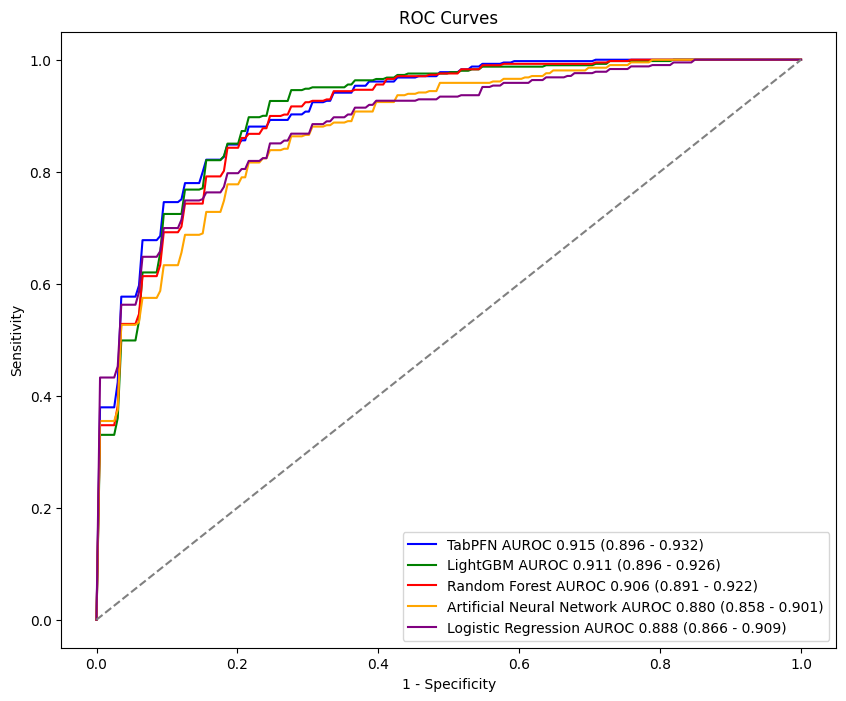

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

plt.figure(figsize=(10, 8))

models = [
    'TabPFN',
    'lightgbm',
    'random_forest',
    'neural_network',
    'logistic_regression'
]

model_names = {
    'TabPFN': 'TabPFN',
    'lightgbm': 'LightGBM',
    'random_forest': 'Random Forest',
    'neural_network': 'Artificial Neural Network',
    'logistic_regression': 'Logistic Regression'
}

colors = {
    'TabPFN': 'blue',
    'lightgbm': 'green',
    'random_forest': 'red',
    'neural_network': 'orange',
    'logistic_regression': 'purple'
}

model_aurocs = {model: [] for model in models}
mean_fprs = np.linspace(0, 1, 200)
tpr_interpolations = {model: [] for model in models}

for model in models:
    if model == 'TabPFN':
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model_instance = TabPFNClassifier(device=device, **best_params[model])
    elif model == 'lightgbm':
        model_instance = lgb.LGBMClassifier(**best_params[model])
    elif model == 'random_forest':
        model_instance = RandomForestClassifier(**best_params[model], random_state=42)
    elif model == 'neural_network':
        model_instance = MLPClassifier(**best_params[model], random_state=42)
    elif model == 'logistic_regression':
        model_instance = LogisticRegression(**best_params[model])

    for train_idx, valid_idx in skf.split(x, y):
        X_train, X_valid = x.iloc[train_idx], x.iloc[valid_idx]
        Y_train, Y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        model_instance.fit(X_train, Y_train)
        probabilities = model_instance.predict_proba(X_valid)[:, 1]
        fpr, tpr, _ = roc_curve(Y_valid, probabilities)
        roc_auc = roc_auc_score(Y_valid, probabilities)
        model_aurocs[model].append(roc_auc)
        interpolated_tpr = np.interp(mean_fprs, fpr, tpr)
        interpolated_tpr[0] = 0.0
        tpr_interpolations[model].append(interpolated_tpr)

for model in models:
    avg_tpr = np.mean(tpr_interpolations[model], axis=0)
    avg_tpr[-1] = 1.0
    avg_auroc = np.mean(model_aurocs[model])
    model_label = f"{model_names[model]} AUROC {avg_auroc:.3f} ({bootstrap_results[model]['roc_auc'][0]:.3f} - {bootstrap_results[model]['roc_auc'][1]:.3f})"
    plt.plot(mean_fprs, avg_tpr, label=model_label, color=colors[model])

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curves')
plt.legend()
plt.savefig('/data/result/roc.png', dpi=300)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we wil

[LightGBM] [Warning] feature_fraction is set=0.4202553475751025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202553475751025
[LightGBM] [Warning] lambda_l2 is set=9.749901192753748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.749901192753748
[LightGBM] [Warning] lambda_l1 is set=0.0015136166431258347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015136166431258347
[LightGBM] [Warning] bagging_fraction is set=0.524654257199868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.524654257199868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.4202553475751025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202553475751025
[LightGBM] [Warning] lambda_l2 is set=9.749901192753748, reg_lambda=0.0 will be ignored.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

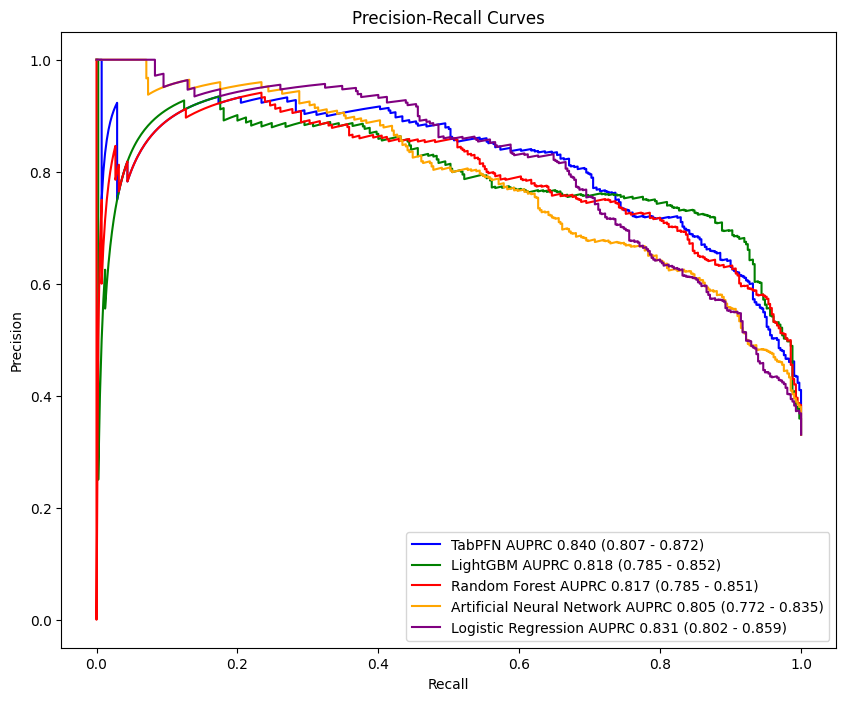

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

plt.figure(figsize=(10, 8))

models = [
    'TabPFN',
    'lightgbm',
    'random_forest',
    'neural_network',
    'logistic_regression'
]

model_names = {
    'TabPFN': 'TabPFN',
    'lightgbm': 'LightGBM',
    'random_forest': 'Random Forest',
    'neural_network': 'Artificial Neural Network',
    'logistic_regression': 'Logistic Regression'
}

colors = {
    'TabPFN': 'blue',
    'lightgbm': 'green',
    'random_forest': 'red',
    'neural_network': 'orange',
    'logistic_regression': 'purple'
}

for model in models:
    if model == 'TabPFN':
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model_instance = TabPFNClassifier(device=device, **best_params[model])
    elif model == 'lightgbm':
        model_instance = lgb.LGBMClassifier(**best_params[model])
    elif model == 'random_forest':
        model_instance = RandomForestClassifier(**best_params[model], random_state=42)
    elif model == 'logistic_regression':
        model_instance = LogisticRegression(**best_params[model])
    elif model == 'neural_network':
        model_instance = MLPClassifier(**best_params[model], random_state=42)

    y_real = []
    y_proba = []
    for train_idx, valid_idx in skf.split(x, y):
        X_train, X_valid = x.iloc[train_idx], x.iloc[valid_idx]
        Y_train, Y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model_instance.fit(X_train, Y_train)
        probabilities = model_instance.predict_proba(X_valid)[:, 1]
        y_real.append(Y_valid)
        y_proba.append(probabilities)

    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    prc_auc = average_precision_score(y_real, y_proba)

    model_label = f"{model_names[model]} AUPRC {prc_auc:.3f} ({bootstrap_results[model]['auprc'][0]:.3f} - {bootstrap_results[model]['auprc'][1]:.3f})"
    plt.plot(recall, precision, label=model_label, color=colors[model])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.savefig('/data/result/prc.png', dpi=300)

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning

[LightGBM] [Warning] feature_fraction is set=0.4202553475751025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202553475751025
[LightGBM] [Warning] lambda_l2 is set=9.749901192753748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.749901192753748
[LightGBM] [Warning] lambda_l1 is set=0.0015136166431258347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015136166431258347
[LightGBM] [Warning] bagging_fraction is set=0.524654257199868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.524654257199868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.4202553475751025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202553475751025
[LightGBM] [Warning] lambda_l2 is set=9.749901192753748, reg_lambda=0.0 will be ignored.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

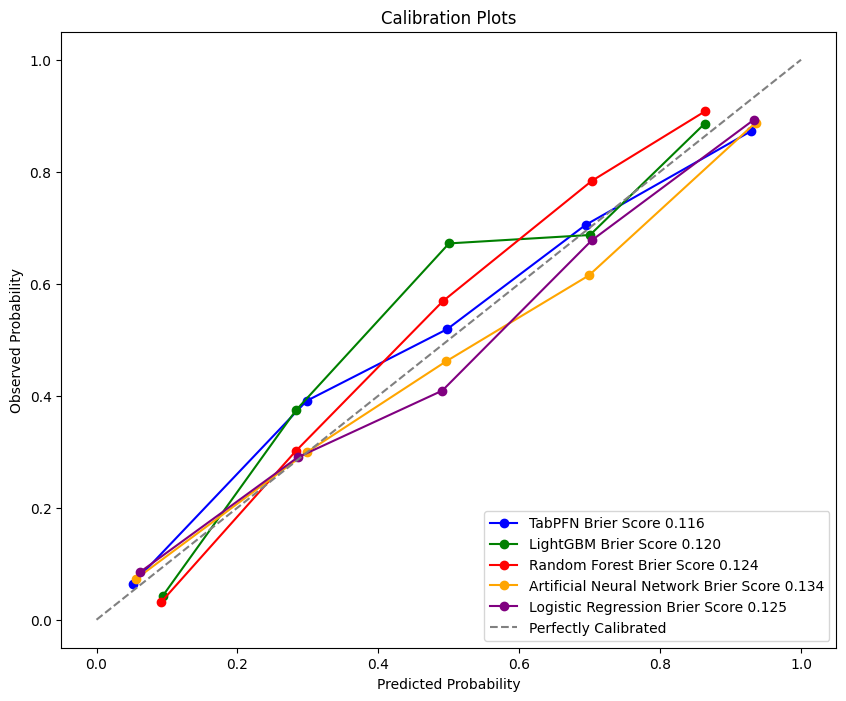

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import numpy as np

models = [
    'TabPFN',
    'lightgbm',
    'random_forest',
    'neural_network',
    'logistic_regression'
]

model_names = {
    'TabPFN': 'TabPFN',
    'lightgbm': 'LightGBM',
    'random_forest': 'Random Forest',
    'neural_network': 'Artificial Neural Network',
    'logistic_regression': 'Logistic Regression'
}

colors = {
    'TabPFN': 'blue',
    'lightgbm': 'green',
    'random_forest': 'red',
    'neural_network': 'orange',
    'logistic_regression': 'purple'
}

plt.figure(figsize=(10, 8))

for model in models:
    if model == 'TabPFN':
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model_instance = TabPFNClassifier(device=device, **best_params[model])
    elif model == 'lightgbm':
        model_instance = lgb.LGBMClassifier(**best_params[model])
    elif model == 'random_forest':
        model_instance = RandomForestClassifier(**best_params[model], random_state=42)
    elif model == 'logistic_regression':
        model_instance = LogisticRegression(**best_params[model])
    elif model == 'neural_network':
        model_instance = MLPClassifier(**best_params[model], random_state=42)

    y_real = []
    y_proba = []
    for train_idx, valid_idx in skf.split(x, y):
        X_train, X_valid = x.iloc[train_idx], x.iloc[valid_idx]
        Y_train, Y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model_instance.fit(X_train, Y_train)
        probabilities = model_instance.predict_proba(X_valid)[:, 1]
        y_real.append(Y_valid)
        y_proba.append(probabilities)

    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_real, y_proba, n_bins=5)

    brier_score = brier_score_loss(y_real, y_proba)

    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', color=colors[model],
             label=f'{model_names[model]} Brier Score {brier_score:.3f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.title('Calibration Plots')
plt.legend(loc="best")
plt.legend(loc="lower right")

save_path = '/data/result/calibration_plots.png'
plt.savefig(save_path, dpi=300)
plt.show()

ストリーミング出力は最後の 5000 行に切り捨てられました。
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/util

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

ストリーミング出力は最後の 5000 行に切り捨てられました。
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

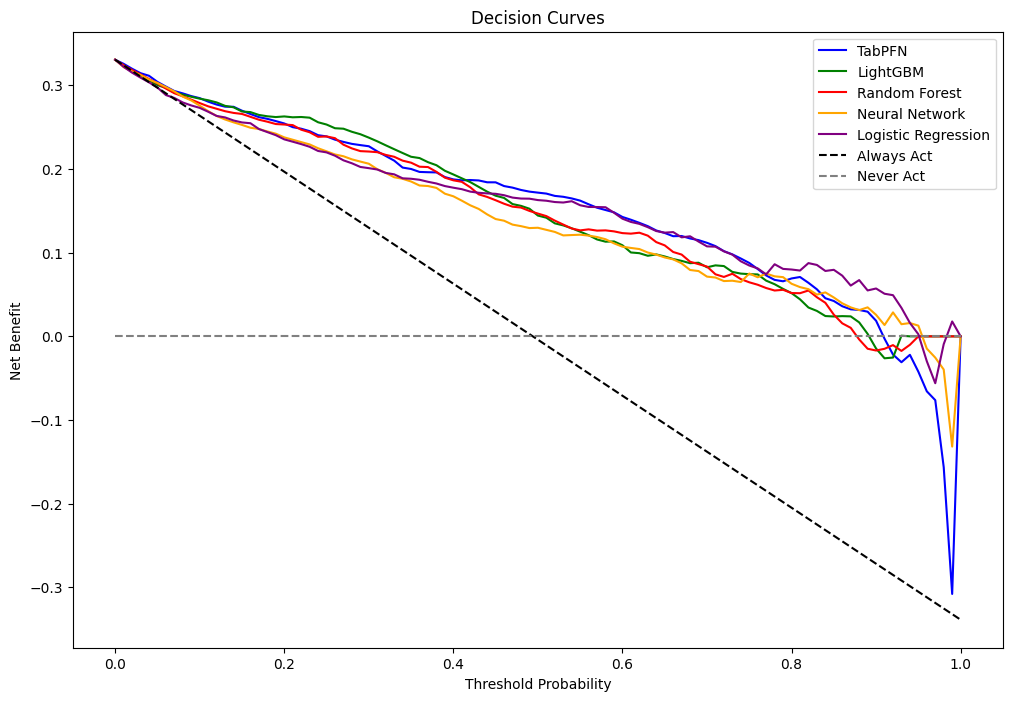

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


models = {
    'TabPFN': TabPFNClassifier(device=device, **best_params['TabPFN']),
    'LightGBM': lgb.LGBMClassifier(**best_params['lightgbm']),
    'Random Forest': RandomForestClassifier(**best_params['random_forest'], random_state=42),
    'Neural Network': MLPClassifier(**best_params['neural_network'], random_state=42),
    'Logistic Regression': LogisticRegression(**best_params['logistic_regression'])
}

colors = {
    'TabPFN': 'blue',
    'LightGBM': 'green',
    'Random Forest': 'red',
    'Logistic Regression': 'purple',
    'Neural Network': 'orange',
    'Always Act': 'black',
    'Never Act': 'gray'
}

def calculate_net_benefit(probabilities, y_true, threshold):
    if threshold >= 1:
        return 0.0
    else:
        predictions = probabilities >= threshold
        tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()
        net_benefit = (tp - (fp * threshold / max(1e-6, (1 - threshold)))) / len(y_true)
        return net_benefit

thresholds = np.arange(0.0, 1.01, 0.01)
prevalence = y.mean()

def calculate_net_benefit_at_threshold(model, threshold):
    net_benefit_list = []
    for train_idx, valid_idx in skf.split(x, y):
        X_train, X_valid = x.iloc[train_idx], x.iloc[valid_idx]
        Y_train, Y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_train, Y_train)
        probabilities = model.predict_proba(X_valid)[:, 1]
        net_benefit = calculate_net_benefit(probabilities, Y_valid, threshold)
        net_benefit_list.append(net_benefit)
    return np.mean(net_benefit_list)

net_benefits = {model_name: [calculate_net_benefit_at_threshold(model, threshold) for threshold in thresholds] for model_name, model in models.items()}

always_act_net_benefit = [prevalence - threshold * (1 - prevalence) for threshold in thresholds]
never_act_net_benefit = [0 for _ in thresholds]

plt.figure(figsize=(12, 8))
for model_name, net_benefit in net_benefits.items():
    plt.plot(thresholds, net_benefit, label=model_name, color=colors[model_name])
plt.plot(thresholds, always_act_net_benefit, label='Always Act', linestyle='--', color=colors['Always Act'])
plt.plot(thresholds, never_act_net_benefit, label='Never Act', linestyle='--', color=colors['Never Act'])

plt.xlabel('Threshold Probability')
plt.ylabel('Net Benefit')
plt.title('Decision Curves')
plt.legend()
plt.savefig('/data/result/DCA.png', dpi=300)